### autompg data
### The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in
### terms of 3 multivalued discrete and 5 continuous attributes.
### mpg: continuous
### cylinders: multi-valued discrete
### displacement: continuous
### horsepower: continuous
### weight: continuous
### acceleration: continuous: 6 missing values are denoted with "?"
### model year: multi-valued discrete
### origin: multi-valued discrete
### car name: string (unique for each instance)

# import essential packages

In [1]:
# needed utilities
import pandas as pd  # for reading and manipulating data in a tabular format
import numpy as np  # for numerical computations and data manipulation
from numpy import emath
import math  # mathematical operations
import random  # for generating random numbers
import itertools

# machine learning/predictive modeling
# for splitting data into training and testing sets and performing cross-validation
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# for building various types of regression models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.model_selection import KFold

# for calculating evaluation metrics for regression models
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# for handling missing data by imputing values based on nearest neighbors
from sklearn.impute import KNNImputer

# for symbolic regression
from gplearn.genetic import SymbolicRegressor

# for plotting and visualizing data
import matplotlib.pyplot as plt  # general visualizations
from mpl_toolkits.mplot3d import Axes3D  # 3D visuals

# for turning off/on warnings tgp
import warnings
import seaborn as sns

# import datasets

In [2]:
autompg = pd.read_csv(
    "/Users/rohithlingala/Documents/Academics/Datascience/scalation_2.0/data/auto-mpg.csv", index_col=None
)  # index_col = None ensure that we do not have indices in our pd.DataFrame object

# Exploratory Analysis

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
model year        int64
origin            int64
car name         object
dtype: object
--------------------
     mpg  cylinders  displacement horsepower  weight  acceleration   
0   18.0          8         307.0        130    3504          12.0  \
1   15.0          8         350.0        165    3693          11.5   
2   18.0          8         318.0        150    3436          11.0   
3   16.0          8         304.0        150    3433          12.0   
4   17.0          8         302.0        140    3449          10.5   
5   15.0          8         429.0        198    4341          10.0   
6   14.0          8         454.0        220    4354           9.0   
7   14.0          8         440.0        215    4312           8.5   
8   14.0          8         455.0        225    4425          10.0   
9   15.0          8         390.0        190    3

array([[<Axes: title={'center': 'mpg'}>,
        <Axes: title={'center': 'cylinders'}>,
        <Axes: title={'center': 'displacement'}>],
       [<Axes: title={'center': 'weight'}>,
        <Axes: title={'center': 'acceleration'}>,
        <Axes: title={'center': 'model year'}>],
       [<Axes: title={'center': 'origin'}>, <Axes: >, <Axes: >]],
      dtype=object)

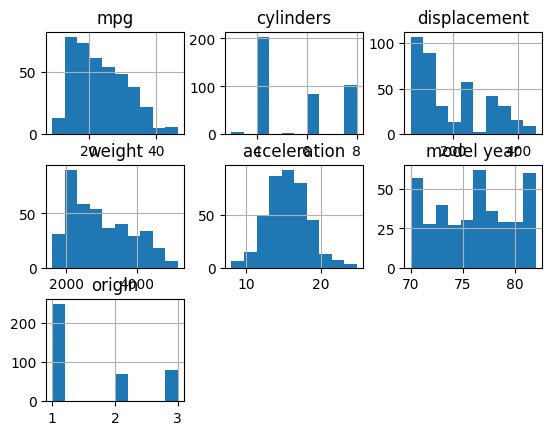

In [3]:
print(autompg.dtypes)  
print("-" * 20)
print(autompg.head(15))
print("-" * 20)
print(autompg.describe())
print("-" * 20)
print(
    len(autompg["car name"].unique())
)  # 305 unique car names. Will no be useful in prediction
autompg.hist()

# Data Preprocessing

### null values and outliers

In [4]:
autompg.replace("?", np.NaN, inplace=True)  # replace "?" with np.Nan
autompg.drop("car name", axis=1, inplace=True)  # car column is useless in prediction
# autompg["horsepower"] = autompg["horsepower"].astype("int64")# casts the horsepower column to int64 datatype
# Convert the data in the DataFrame to a numpy array
data = np.array(autompg)
# Use KNNImputer to impute missing values
imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(data)
# Convert the imputed numpy array back to a pandas DataFrame
autompg = pd.DataFrame(imputed_data, columns=autompg.columns)
autompg.to_csv("/Users/rohithlingala/Documents/Academics/Datascience/scalation_2.0/data/Auto.csv")

In [5]:
null_values = autompg.isnull().sum()  # autompg.isnull returns an array of booleans
print(null_values)  # no null values, no imputation needed


def find_outliers_z_score(df: pd.DataFrame, column: str) -> pd.DataFrame:
    mean = df[column].mean()
    std_deviation = df[column].std()
    z_scores = (df[column] - mean) / std_deviation
    outliers = df[np.abs(z_scores) > 3]
    if len(outliers) > 0:
        return pd.DataFrame(outliers)
    else:
        return "No outliers"


print("-" * 50)
print(
    "Outliers according to Z score"
)  # outliers are points with a z score greater than 3
for colName in autompg.columns:
    print("Column name:", colName)
    print(find_outliers_z_score(autompg, colName))
    print()
print("-" * 50)

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
dtype: int64
--------------------------------------------------
Outliers according to Z score
Column name: mpg
No outliers

Column name: cylinders
No outliers

Column name: displacement
No outliers

Column name: horsepower
      mpg  cylinders  displacement  horsepower  weight  acceleration   
6    14.0        8.0         454.0       220.0  4354.0           9.0  \
8    14.0        8.0         455.0       225.0  4425.0          10.0   
13   14.0        8.0         455.0       225.0  3086.0          10.0   
95   12.0        8.0         455.0       225.0  4951.0          11.0   
116  16.0        8.0         400.0       230.0  4278.0           9.5   

     model year  origin  
6          70.0     1.0  
8          70.0     1.0  
13         70.0     1.0  
95         73.0     1.0  
116        73.0     1.0  

Column name: weight
No outliers

Column nam

### feature selection using variance, covariance, and correlation

----- Variance -----
                   Variance
mpg               61.089611
cylinders          2.893415
displacement   10872.199152
horsepower      1470.548269
weight        717140.990526
acceleration       7.604848
model year        13.672443
origin             0.643292
----------------------------------------------------------------------
----- Covariance -----
                      mpg    cylinders  displacement    horsepower   
mpg             61.089611   -10.308911   -655.402318   -233.013143  \
cylinders      -10.308911     2.893415    168.623214     54.951184   
displacement  -655.402318   168.623214  10872.199152   3587.879792   
horsepower    -233.013143    54.951184   3587.879792   1470.548269   
weight       -5505.211745  1290.695575   82368.42324  28093.221075   
acceleration      9.05893    -2.370842   -156.332976     -72.85599   
model year      16.741163    -2.193499   -142.717137    -58.544372   
origin           3.532185    -0.767477    -50.964989    -13.904756   

  

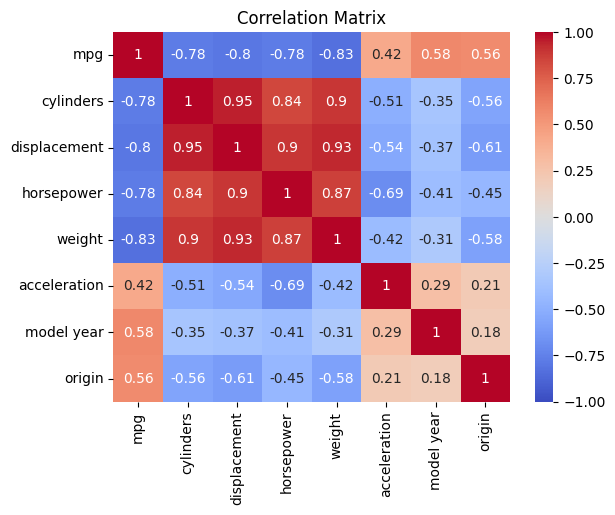

----------------------------------------------------------------------


In [6]:
# Checking the variance of the numerical columns, if variance = 0, column is not longer in original dataset
def check_variance(df: pd.DataFrame) -> pd.DataFrame:
    # create pd.DataFrame to store the column names and their variance with each other
    variance_df = pd.DataFrame(columns=["Variance"], index=df.columns)
    variance_df.fillna(0, inplace=True)
    for colName in df.columns:
        variance_df.loc[colName, "Variance"] = df[colName].var()
    return variance_df


def check_covariance(df: pd.DataFrame) -> pd.DataFrame:
    # create pd.DataFrame to store the column names and their covariance with each other
    covariance_df = pd.DataFrame(index=df.columns, columns=df.columns)
    # check covariance between all columns and append the covariance in the correct spot
    for col1 in df.columns:
        for col2 in df.columns:
            covariance_df.loc[col1, col2] = df[col1].cov(df[col2])
            # covariance_df.loc[col1, col2]: row label col1, column label col2
    return covariance_df

print("----- Variance -----")
print(check_variance(autompg))
print("-" * 70)
print("----- Covariance -----")
print(
    check_covariance(autompg)
)  # notice that the covariance between a column and itself is the variance of that column
print("-" * 70)
print("----- Correlation -----")
print(autompg.corr())
cor = autompg.corr()
sns.heatmap(cor, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()
print("-" * 70)

, 


In [7]:
def shuffle_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    # add a random seed to ensure randomness
    random.seed(42)
    # shuffle the indices of the pd.DataFrame
    df = df.reindex(np.random.permutation(df.index))
    # df.index = current values of indices of a pd.DataFrame. returns an array
    # np.random.permutation(df.index) = shuffles the supplied array
    # df.reindex(np.random.permutation(df.index)) = applied the shuffled indices to the pd.DataFrame object
    return df


# define adjusted r2 function
def adjusted_r2_score(XTest: pd.DataFrame, r2: float) -> float:
    n = XTest.shape[0]  # number of rows
    p = XTest.shape[1]  # number of columns
    adj_r2 = 1 - (1 - r2) * (n - 1) / (
        n - p - 1
    )  # adjusted r squared formula, applies penalty to the use of extra parameters
    return adj_r2

In [8]:
printOn = False  # control print statements below
autompg = shuffle_dataframe(autompg)
X = pd.DataFrame(autompg.drop("mpg", axis=1))
y = pd.DataFrame(autompg[["mpg"]])

columns = X.columns
columnCombos = []

for i in range(2, len(columns) + 1):
    columnCombos.extend(list(itertools.combinations(columns, i)))
    # itertools.combination(iterable, length of iterable) generates all unqiue combiation of an iterable at length
    # list() casts the iterools object into a list so we can extend columnCombos
    # list.extend adds multiple elements to the end of a list
    
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=True, shuffle=True
)

# Define a function to calculate adjusted R-squared
def adj_r2_score(r2, n, k):
    return 1 - ((1 - r2) * (n - 1)) / (n - k - 1)

# Turn off warnings
warnings.filterwarnings("ignore")  # category = UserWarning

# Linear Regression

----------------------------------------------------------------------------------------------------
In Sample Linear Regresssion


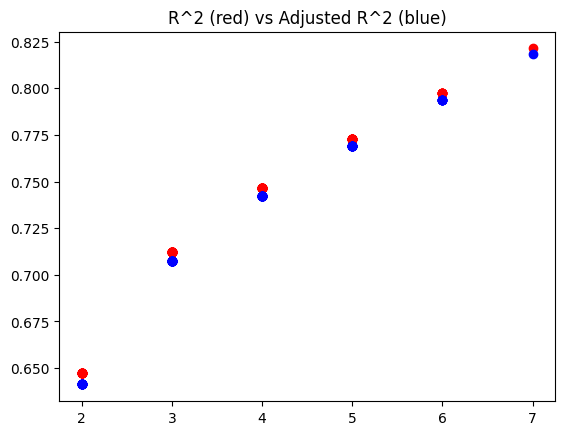

On average, the number of parameters that seem optimal for a simple linear regression model is 7.0
Based on R Squared/Adjusted R Squared calculations the optimal combinations are:
['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']
['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']


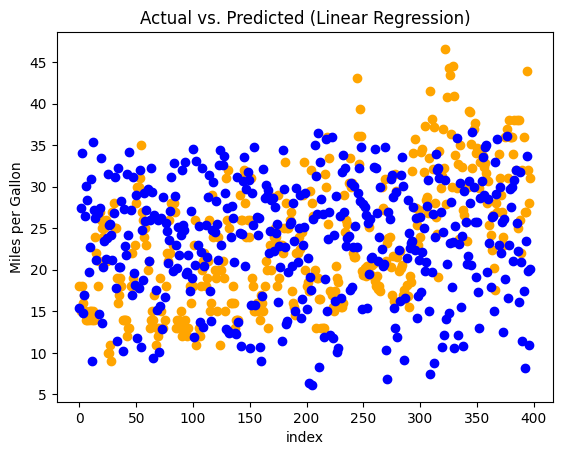

MAE: 2.5070
MSE: 10.8875
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Train and Test Linear Regresssion


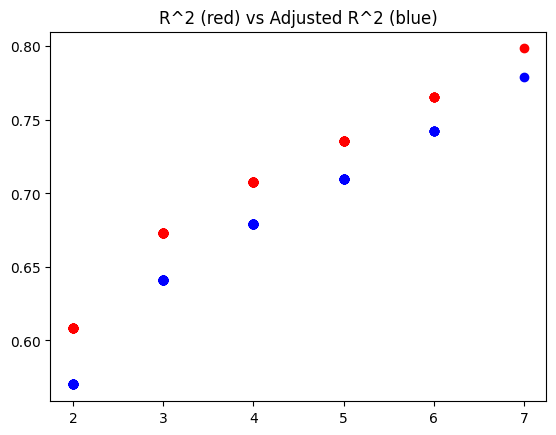

On average, the number of parameters that seem optimal for a simple linear regression model is 4.0
Based on R Squared/Adjusted R Squared calculations the optimal combinations are:
['displacement', 'weight', 'model year', 'origin']: R Squared: 0.8104793217335428
['displacement', 'weight', 'model year', 'origin']: Adjusted R Squared 0.792053700235415


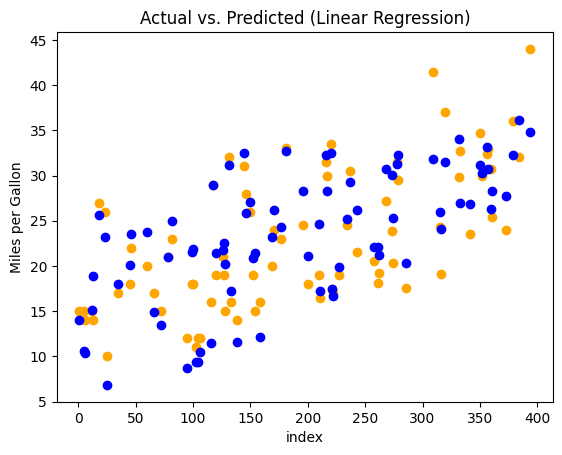

MAE: 2.7462
MSE: 11.3563
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Five Fold Cross Validation- Linear Regression
Mean R-squared score: 0.813 (+/- 0.043)
Linear Regression Mean Adjusted R-squared score: 0.810 (+/- 0.044)
----------------------------------------------------------------------------------------------------


In [9]:
print("-" * 100)
print("In Sample Linear Regresssion")
numberOptimalParameters = []
linearRegressionR2 = {}
linearRegressionadjustedR2 = {}

for i in range(10):
    maxR2 = 0
    maxAdjR2 = 0
    bestcombo1 = ""
    bestcombo2 = ""
    for combination in columnCombos:
        # create a linear regression model
        linearRegressionModel = LinearRegression()
        # fit the model to the training data
        combination = list(combination)
        linearRegressionModel.fit(X[combination], y)
        # make predictions on the test data
        y_predictions = linearRegressionModel.predict(X[combination])
        # r2 score
        r2 = r2_score(y, y_predictions)
        # calculate adjusted r2
        adj_r2 = adjusted_r2_score(X, r2)
        if r2 > maxR2 and adj_r2 > maxAdjR2:
            maxR2 = r2
            bestCombo1 = str(combination)
            maxAdjR2 = adj_r2
            bestCombo2 = str(combination)
        if printOn:
            print("---------- Performance Evaluation ----------")
            print("Best R Squared combination")
            print(f"{len(eval(bestCombo1))} parameters\n{bestCombo1}:\nR^2: {r2}")
            print("Best Adjusted R Squared combination")
            print(f"{len(eval(bestCombo2))} parameters\n{bestCombo2}:\nR^2: {adj_r2}")
            print("--------------------------------------------")
            # append column combination and calculated metrics to respective dictionaries
        linearRegressionR2[str(combination)] = r2
        linearRegressionadjustedR2[str(combination)] = adj_r2
    numberOptimalParameters.append(len(eval(bestCombo1)))
    numberOptimalParameters.append(len(eval(bestCombo2)))

num_params = [
    len(eval(key)) for key in linearRegressionR2.keys()
]  # get the number of parameters for each column combination
# create a visualization averaging all R2 and adjusted R2 generated for their respective paramters used
for element in num_params:
    sumList = []
    for i in range(len(linearRegressionR2)):
        if len(eval(list(linearRegressionR2.keys())[i])) == element:
            sumList.append(float(list(linearRegressionR2.values())[i]))
    plt.scatter(element, sum(sumList) / len(sumList), label="R^2", c="red", marker="o")


for element in num_params:
    sumList = []
    for i in range(len(linearRegressionadjustedR2)):
        if len(eval(list(linearRegressionadjustedR2.keys())[i])) == element:
            sumList.append(float(list(linearRegressionadjustedR2.values())[i]))
    plt.scatter(
        element, sum(sumList) / len(sumList), label="Adjusted R^2", c="blue", marker="o"
    )

plt.title("R^2 (red) vs Adjusted R^2 (blue)")
plt.show()

print(
    f"On average, the number of parameters that seem optimal for a simple linear regression model is {round(sum(numberOptimalParameters)/len(numberOptimalParameters), 2)}"
)
print(
    f"Based on R Squared/Adjusted R Squared calculations the optimal combinations are:\n{str(bestCombo1)}\n{str(bestCombo2)}"
)
plt.scatter(y.index, y, c="orange")
plt.scatter(pd.DataFrame(y_predictions).index, y_predictions, c="blue")
plt.title("Actual vs. Predicted (Linear Regression)")
plt.xlabel("index")
plt.ylabel("Miles per Gallon")
plt.show()
# calculate and dispaly residual metrics
mae = mean_absolute_error(y, y_predictions)
mse = mean_squared_error(y, y_predictions)
print(
    f"MAE: {mae:.4f}"
)  # MAE: average of the absoulte differences. Less sensitive to outliers
print(
    f"MSE: {mse:.4f}"
)  # MSE: average of the squared differences. More sensitive to outliers
print("-" * 100)

########################################################################################################################

print("-" * 100)
print("Train and Test Linear Regresssion")
numberOptimalParameters = []
linearRegressionR2 = {}
linearRegressionadjustedR2 = {}

for i in range(10):
    maxR2 = 0
    maxAdjR2 = 0
    bestcombo1 = ""
    bestcombo2 = ""
    for combination in columnCombos:
        # create a linear regression model
        linearRegressionModel = LinearRegression()
        # fit the model to the training data
        combination = list(combination)
        linearRegressionModel.fit(X_train[combination], y_train)
        # make predictions on the test data
        y_predictions = linearRegressionModel.predict(X_test[combination])
        # r2 score
        r2 = r2_score(y_test, y_predictions)
        # calculate adjusted r2
        adj_r2 = adjusted_r2_score(X_test, r2)
        if r2 > maxR2:
            maxR2 = r2
            bestCombo1 = str(combination)
        if adj_r2 > maxAdjR2:
            maxAdjR2 = adj_r2
            bestCombo2 = str(combination)
        if printOn:
            print("---------- Performance Evaluation ----------")
            print("Best R Squared combination")
            print(f"{len(eval(bestCombo1))} parameters\n{bestCombo1}:\nR^2: {r2}")
            print("Best Adjusted R Squared combination")
            print(f"{len(eval(bestCombo2))} parameters\n{bestCombo2}:\nR^2: {adj_r2}")
            print("--------------------------------------------")
            # append column combination and calculated metrics to respective dictionaries
        linearRegressionR2[str(combination)] = r2
        linearRegressionadjustedR2[str(combination)] = adj_r2
    numberOptimalParameters.append(len(eval(bestCombo1)))
    numberOptimalParameters.append(len(eval(bestCombo2)))

num_params = [
    len(eval(key)) for key in linearRegressionR2.keys()
]  # get the number of parameters for each column combination
# create a visualization averaging all R2 and adjusted R2 generated for their respective paramters used
for element in num_params:
    sumList = []
    for i in range(len(linearRegressionR2)):
        if len(eval(list(linearRegressionR2.keys())[i])) == element:
            sumList.append(float(list(linearRegressionR2.values())[i]))
    plt.scatter(element, sum(sumList) / len(sumList), label="R^2", c="red", marker="o")


for element in num_params:
    sumList = []
    for i in range(len(linearRegressionadjustedR2)):
        if len(eval(list(linearRegressionadjustedR2.keys())[i])) == element:
            sumList.append(float(list(linearRegressionadjustedR2.values())[i]))
    plt.scatter(
        element, sum(sumList) / len(sumList), label="Adjusted R^2", c="blue", marker="o"
    )

plt.title("R^2 (red) vs Adjusted R^2 (blue)")
plt.show()

print(
    f"On average, the number of parameters that seem optimal for a simple linear regression model is {round(sum(numberOptimalParameters)/len(numberOptimalParameters), 2)}"
)
print(
    f"Based on R Squared/Adjusted R Squared calculations the optimal combinations are:\n{str(bestCombo1)}: R Squared: {maxR2}\n{str(bestCombo2)}: Adjusted R Squared {maxAdjR2}"
)
plt.scatter(y_test.index, y_test, c="orange")
plt.scatter(y_test.index, y_predictions, c="blue")
plt.title("Actual vs. Predicted (Linear Regression)")
plt.xlabel("index")
plt.ylabel("Miles per Gallon")
plt.show()
# calculate and dispaly residual metrics
mae = mean_absolute_error(y_test, y_predictions)
mse = mean_squared_error(y_test, y_predictions)
print(
    f"MAE: {mae:.4f}"
)  # MAE: average of the absoulte differences. Less sensitive to outliers
print(
    f"MSE: {mse:.4f}"
)  # MSE: average of the squared differences. More sensitive to outliers
print("-" * 100)
########################################################################################################################
print("-" * 100)
print("Five Fold Cross Validation- Linear Regression")
# Create a LinearRegression object
linearRegression = LinearRegression()
# Use cross-validation to evaluate the performance of the model
scores = cross_val_score(linearRegression, X, y, cv=5, scoring="r2")
# Calculate adjusted R-squared
adj_scores = [adj_r2_score(r2, X.shape[0], X.shape[1]) for r2 in scores]
# Print the mean score and standard deviation of the scores
print("Mean R-squared score: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
print(
    "Linear Regression Mean Adjusted R-squared score: %0.3f (+/- %0.3f)"
    % (np.mean(adj_scores), np.std(adj_scores) * 2)
)
print("-" * 100)

# Lasso Regression

----------------------------------------------------------------------------------------------------
Lasso Regresssion

Using Lambda and Input Features to Measure R Squared


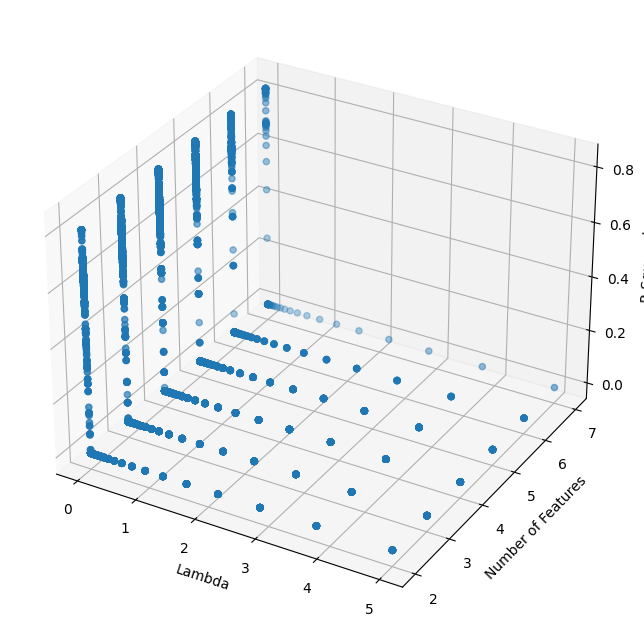

Using Lambda and Input Features to Measure Adjusted R Squared


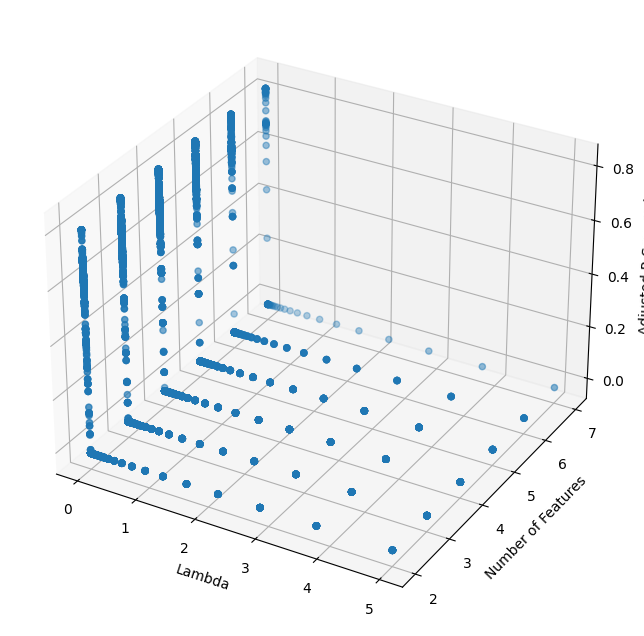

On average, the number of parameters that seem optimal for a Lasso Linear regression model is 7.0
Based on R Squared/Adjusted R Squared calculations the optimal column/lambda combinations are:
['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin'] / 0.0
['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin'] / 0.0


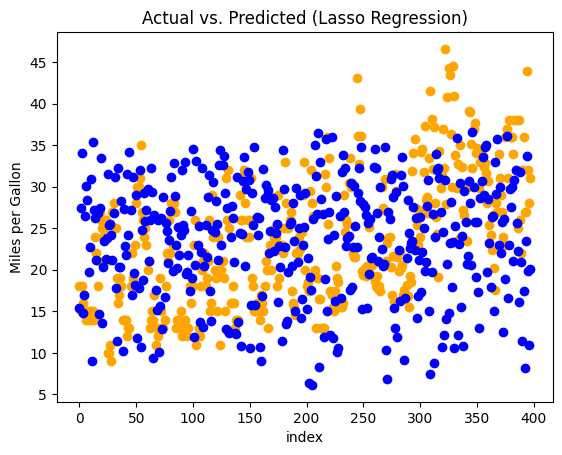

MAE: 2.5070
MSE: 10.8875
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Lasso Regresssion

Using Lambda and Input Features to Measure R Squared


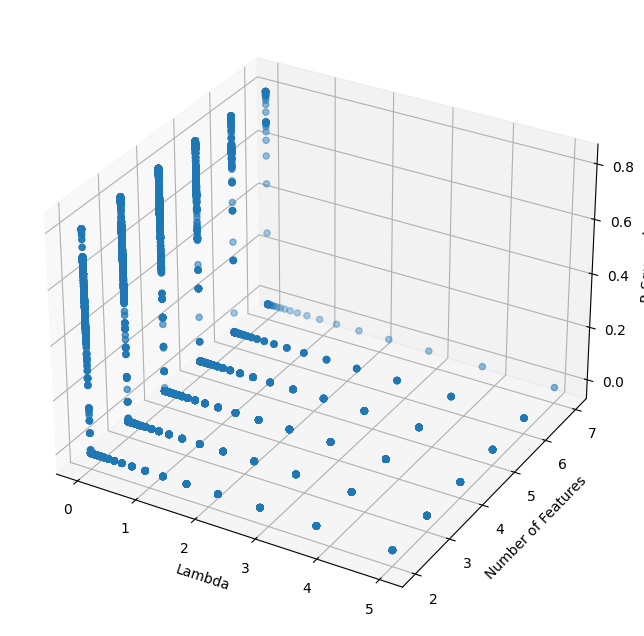

Using Lambda and Input Features to Measure Adjusted R Squared


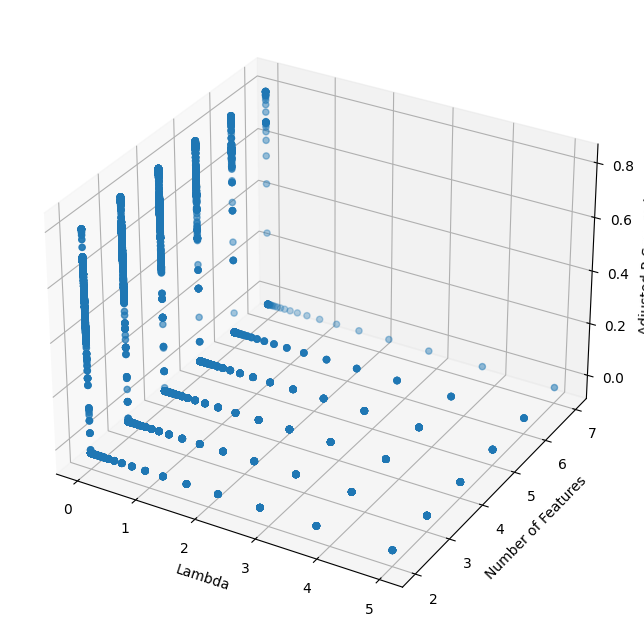

On average, the number of parameters that seem optimal for a Lasso Linear regression model is 7.0
Based on R Squared/Adjusted R Squared calculations the optimal combinations are:
['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']: R Squared: 0.7996033524054446
['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']: Adjusted R Squared 0.7960064894999013


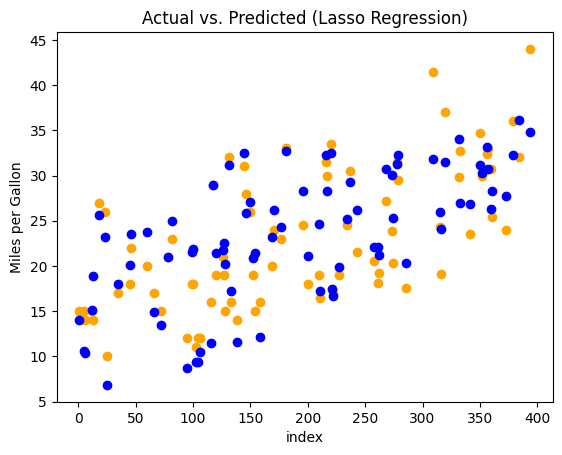

MAE: 2.7462
MSE: 11.3563
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Five Fold Cross Validation Lasso Regression
LassoCV Mean R-squared score: 0.813 (+/- 0.042)
LassoCV Mean Adjusted R-squared score: 0.809 (+/- 0.043)
LassoCV Optimal lambda: 0.067
----------------------------------------------------------------------------------------------------


In [10]:
print("-" * 100)
print("Lasso Regresssion")
print()

numberOptimalParameters = []
lassoLambda = []  # lambda value being used
lassoNumberFeatures = []  # number of features used
lassoR2 = (
    []
)  # R2 values produced by a lasso model with a certain lambda and column combo
lassoAdjR2 = (
    []
)  # Adjusted R2 values produced by a lasso model with a certain lambda and column combo
lambdaParameters = list(10 ** np.linspace(10, -2, 100) * 0.5) + [
    0.0
]  # create parameter space
lambda1 = 0
lambda2 = 0
# create a loop that will iterate through lambda values parameter space and all possible column combinations
maxR2 = 0
maxAdjR2 = 0
bestcombo1 = ""
bestcombo2 = ""
for combination in columnCombos:
    maxR2 = 0
    maxAdjR2 = 0
    # create a lasso regression model
    for lp in lambdaParameters:
        lassoRegressionModel = Lasso(alpha=lp)
        # fit the model to the training data
        combination = list(combination)
        lassoRegressionModel.fit(X[combination], y)
        # make predictions on the test data
        y_predictions = lassoRegressionModel.predict(X[combination])
        # r2 score
        r2 = r2_score(y, y_predictions)
        # calculate adjusted r2
        adj_r2 = adjusted_r2_score(X, r2)
        if r2 > maxR2:
            maxR2 = r2
            bestCombo1 = str(combination)
            lambda1 = lp
        if adj_r2 > maxAdjR2:
            maxAdjR2 = adj_r2
            bestCombo2 = str(combination)
            lambda2 = lp
        # append data in order
        lassoLambda.append(lp)
        lassoNumberFeatures.append(len(combination))
        lassoR2.append(r2)
        lassoAdjR2.append(adj_r2)
    if printOn:
        print("---------- Performance Evaluation ----------")
        print("Best R Squared combination")
        print(f"{len(eval(bestCombo1))} parameters\n{bestCombo1}:\nR^2: {r2}")
        print("Associated lambda value: " + str(lambda1))
        print("Best Adjusted R Squared combination")
        print(f"{len(eval(bestCombo2))} parameters\n{bestCombo2}:\nR^2: {adj_r2}")
        print("Associated lambda value: " + str(lambda2))
        print("--------------------------------------------")
numberOptimalParameters.append(len(eval(bestCombo1)))
numberOptimalParameters.append(len(eval(bestCombo2)))

print("Using Lambda and Input Features to Measure R Squared")
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": "3d"})
# plot the data
ax.scatter(lassoLambda, lassoNumberFeatures, lassoR2)
# set labels
ax.set_xlabel("Lambda")
ax.set_ylabel("Number of Features")
ax.set_zlabel("R Squared")
plt.show()

print("Using Lambda and Input Features to Measure Adjusted R Squared")
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": "3d"})
# plot the data
ax.scatter(lassoLambda, lassoNumberFeatures, lassoAdjR2)
# set labels
ax.set_xlabel("Lambda")
ax.set_ylabel("Number of Features")
ax.set_zlabel("Adjusted R Squared")
plt.show()

print(
    f"On average, the number of parameters that seem optimal for a Lasso Linear regression model is {round(sum(numberOptimalParameters)/len(numberOptimalParameters), 2)}"
)
print(
    f"Based on R Squared/Adjusted R Squared calculations the optimal column/lambda combinations are:\n{str(bestCombo1)} / {lambda1}\n{str(bestCombo2)} / {lambda2}"
)

plt.scatter(y.index, y, c="orange")
plt.scatter(pd.DataFrame(y_predictions).index, y_predictions, c="blue")
plt.title("Actual vs. Predicted (Lasso Regression)")
plt.xlabel("index")
plt.ylabel("Miles per Gallon")
plt.show()
# calculate and dispaly residual metrics
mae = mean_absolute_error(y, y_predictions)
mse = mean_squared_error(y, y_predictions)
print(
    f"MAE: {mae:.4f}"
)  # MAE: average of the absoulte differences. Less sensitive to outliers
print(
    f"MSE: {mse:.4f}"
)  # MSE: average of the squared differences. More sensitive to outliers
print("-" * 100)

########################################################################################################################


print("-" * 100)
print("Lasso Regresssion")
print()

numberOptimalParameters = []
lassoLambda = []  # lambda value being used
lassoNumberFeatures = []  # number of features used
lassoR2 = (
    []
)  # R2 values produced by a lasso model with a certain lambda and column combo
lassoAdjR2 = (
    []
)  # Adjusted R2 values produced by a lasso model with a certain lambda and column combo
lambdaParameters = list(10 ** np.linspace(10, -2, 100) * 0.5) + [
    0.0
]  # create parameter space
lambda1 = 0
lambda2 = 0
# create a loop that will iterate through lambda values parameter space and all possible column combinations
maxR2 = 0
maxAdjR2 = 0
bestcombo1 = ""
bestcombo2 = ""
for combination in columnCombos:
    maxR2 = 0
    maxAdjR2 = 0
    # create a lasso regression model
    for lp in lambdaParameters:
        lassoRegressionModel = Lasso(alpha=lp)
        # fit the model to the training data
        combination = list(combination)
        lassoRegressionModel.fit(X_train[combination], y_train)
        # make predictions on the test data
        y_predictions = lassoRegressionModel.predict(X_test[combination])
        # r2 score
        r2 = r2_score(y_test, y_predictions)
        # calculate adjusted r2
        adj_r2 = adjusted_r2_score(X, r2)
        if r2 > maxR2:
            maxR2 = r2
            bestCombo1 = str(combination)
            lambda1 = lp
        if adj_r2 > maxAdjR2:
            maxAdjR2 = adj_r2
            bestCombo2 = str(combination)
            lambda2 = lp
        # append data in order
        lassoLambda.append(lp)
        lassoNumberFeatures.append(len(combination))
        lassoR2.append(r2)
        lassoAdjR2.append(adj_r2)
    if printOn:
        print("---------- Performance Evaluation ----------")
        print("Best R Squared combination")
        print(f"{len(eval(bestCombo1))} parameters\n{bestCombo1}:\nR^2: {r2}")
        print("Associated lambda value: " + str(lambda1))
        print("Best Adjusted R Squared combination")
        print(f"{len(eval(bestCombo2))} parameters\n{bestCombo2}:\nR^2: {adj_r2}")
        print("Associated lambda value: " + str(lambda2))
        print("--------------------------------------------")
numberOptimalParameters.append(len(eval(bestCombo1)))
numberOptimalParameters.append(len(eval(bestCombo2)))

print("Using Lambda and Input Features to Measure R Squared")
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": "3d"})
# plot the data
ax.scatter(lassoLambda, lassoNumberFeatures, lassoR2)
# set labels
ax.set_xlabel("Lambda")
ax.set_ylabel("Number of Features")
ax.set_zlabel("R Squared")
plt.show()

print("Using Lambda and Input Features to Measure Adjusted R Squared")
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": "3d"})
# plot the data
ax.scatter(lassoLambda, lassoNumberFeatures, lassoAdjR2)
# set labels
ax.set_xlabel("Lambda")
ax.set_ylabel("Number of Features")
ax.set_zlabel("Adjusted R Squared")
plt.show()

print(
    f"On average, the number of parameters that seem optimal for a Lasso Linear regression model is {round(sum(numberOptimalParameters)/len(numberOptimalParameters), 2)}"
)
print(
    f"Based on R Squared/Adjusted R Squared calculations the optimal combinations are:\n{str(bestCombo1)}: R Squared: {maxR2}\n{str(bestCombo2)}: Adjusted R Squared {maxAdjR2}"
)

plt.scatter(y_test.index, y_test, c="orange")
plt.scatter(y_test.index, y_predictions, c="blue")
plt.title("Actual vs. Predicted (Lasso Regression)")
plt.xlabel("index")
plt.ylabel("Miles per Gallon")
plt.show()
# calculate and dispaly residual metrics
mae = mean_absolute_error(y_test, y_predictions)
mse = mean_squared_error(y_test, y_predictions)
print(
    f"MAE: {mae:.4f}"
)  # MAE: average of the absoulte differences. Less sensitive to outliers
print(
    f"MSE: {mse:.4f}"
)  # MSE: average of the squared differences. More sensitive to outliers
print("-" * 100)

########################################################################################################################
print("-" * 100)
print("Five Fold Cross Validation Lasso Regression")
# Create a LassoCV object
lassoCV = LassoCV(cv=5, alphas=np.linspace(0.01, 6, 107))
# Fit the model to the data
lassoCV.fit(X, y)
# Calculate the optimal lambda hyperparameter
lasso_lambda = lassoCV.alpha_
# Use cross-validation to evaluate the performance of the model
scores = cross_val_score(lassoCV, X, y, cv=5, scoring="r2")
# Calculate adjusted R-squared
adj_scores = [adj_r2_score(r2, X.shape[0], X.shape[1]) for r2 in scores]
# Print the mean score and standard deviation of the scores
print(
    "LassoCV Mean R-squared score: %0.3f (+/- %0.3f)"
    % (np.mean(scores), np.std(scores) * 2)
)
print(
    "LassoCV Mean Adjusted R-squared score: %0.3f (+/- %0.3f)"
    % (np.mean(adj_scores), np.std(adj_scores) * 2)
)
print("LassoCV Optimal lambda: %0.3f" % lasso_lambda)
print("-" * 100)
########################################################################################################################

# Ridge Regression

----------------------------------------------------------------------------------------------------
Ridge Regresssion

Using Lambda and Input Features to Measure R Squared


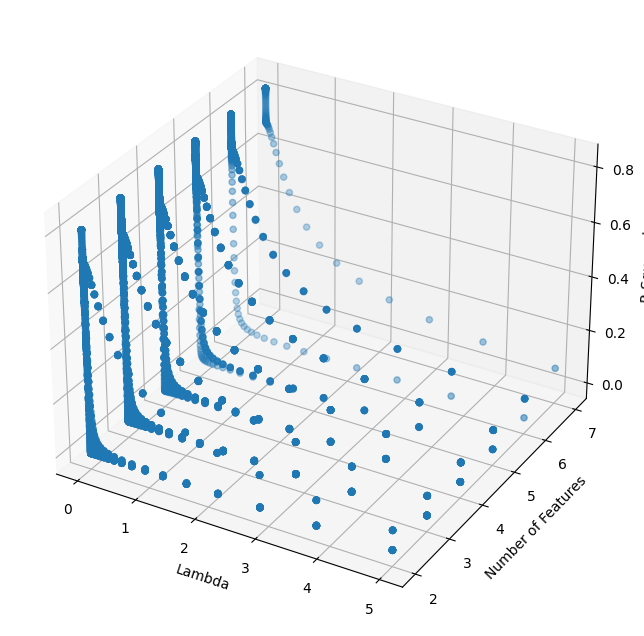

Using Lambda and Input Features to Measure Adjusted R Squared


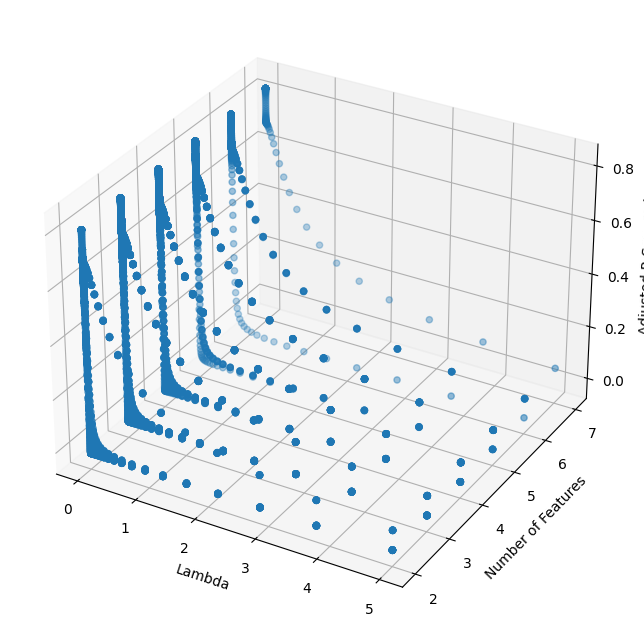

On average, the number of parameters that seem optimal for a Lasso Linear regression model is 3.67
Based on R Squared/Adjusted R Squared calculations the optimal column/lambda combinations are:
['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin'] / 0.0
['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin'] / 0.0


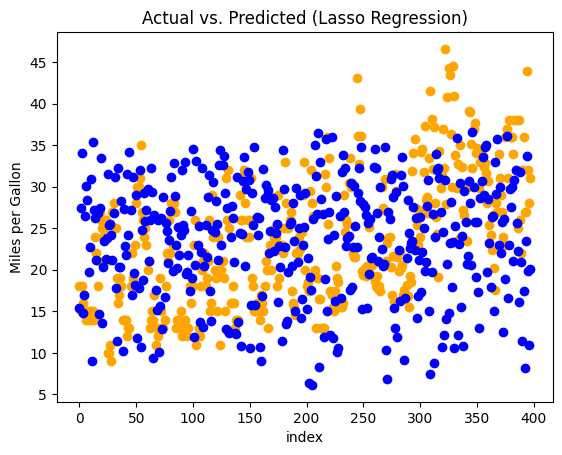

MAE: 2.5070
MSE: 10.8875
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Ridge Regresssion

Using Lambda and Input Features to Measure R Squared


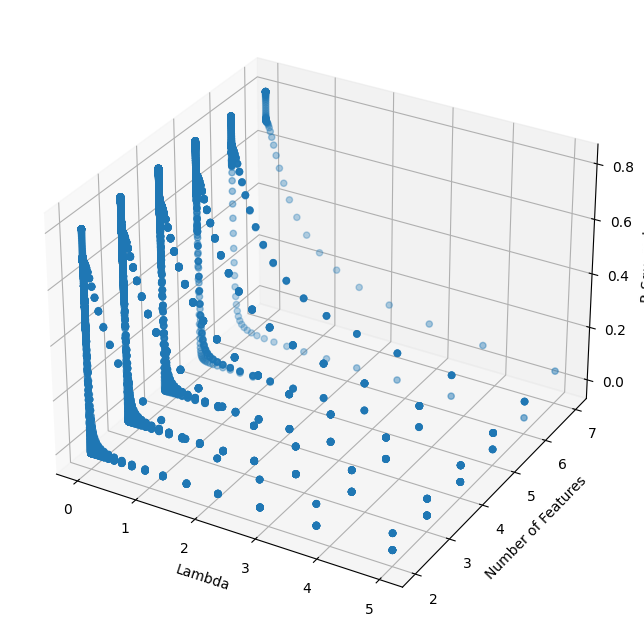

Using Lambda and Input Features to Measure Adjusted R Squared


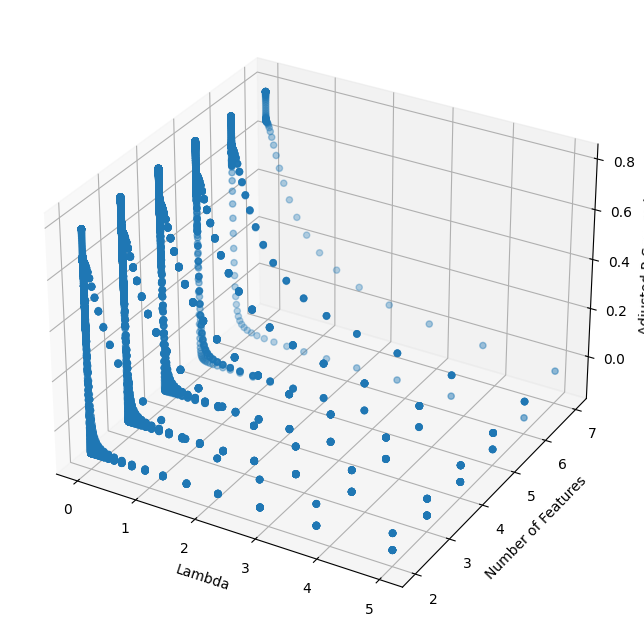

On average, the number of parameters that seem optimal for a Lasso Linear regression model is 3.67
Based on R Squared/Adjusted R Squared calculations the optimal combinations are:
['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']: R Squared: 0.7990001971837806
['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']: Adjusted R Squared 0.7794585496877593


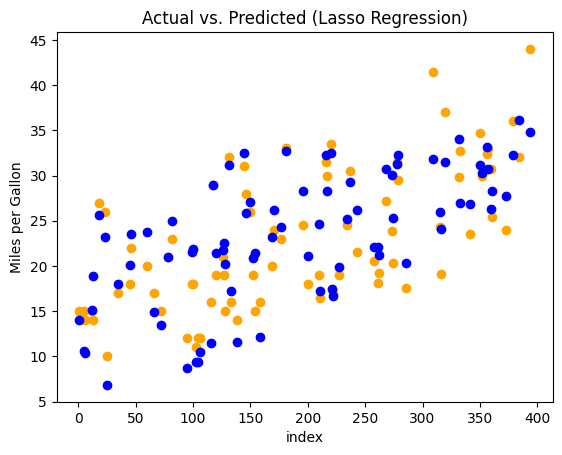

MAE: 2.7462
MSE: 11.3563
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Five Fold Cross Validation Ridge Regression
RidgeCV Mean R-squared score: 0.813 (+/- 0.043)
RidgeCV Mean Adjusted R-squared score: 0.810 (+/- 0.044)
RidgeCV Optimal lambda: 6.000
----------------------------------------------------------------------------------------------------


In [11]:
print("-" * 100)
print("Ridge Regresssion")
print()

numberOptimalParameters = []
ridgeLambda = []  # lambda value being used
ridgeNumberFeatures = []  # number of features used
ridgeR2 = (
    []
)  # R2 values produced by a lasso model with a certain lambda and column combo
ridgeAdjR2 = (
    []
)  # Adjusted R2 values produced by a lasso model with a certain lambda and column combo
lambdaParameters = list(10 ** np.linspace(10, -2, 100) * 0.5) + [
    0.0
]  # create parameter space
lambda1 = 0
lambda2 = 0
# create a loop that will iterate through lambda values parameter space and all possible column combinations
maxR2 = 0
maxAdjR2 = 0
bestcombo1 = ""
bestcombo2 = ""
for combination in columnCombos:
    maxR2 = 0
    maxAdjR2 = 0
    # create a lasso regression model
    for lp in lambdaParameters:
        ridgeRegressionModel = Ridge(alpha=lp)
        # fit the model to the training data
        combination = list(combination)
        ridgeRegressionModel.fit(X[combination], y)
        # make predictions on the test data
        y_predictions = ridgeRegressionModel.predict(X[combination])
        # r2 score
        r2 = r2_score(y, y_predictions)
        # calculate adjusted r2
        adj_r2 = adjusted_r2_score(X, r2)
        if r2 > maxR2:
            maxR2 = r2
            bestCombo1 = str(combination)
            lambda1 = lp
        if adj_r2 > maxAdjR2:
            maxAdjR2 = adj_r2
            bestCombo2 = str(combination)
            lambda2 = lp
        # append data in order
        ridgeLambda.append(lp)
        ridgeNumberFeatures.append(len(combination))
        ridgeR2.append(r2)
        ridgeAdjR2.append(adj_r2)
    if printOn:
        print("---------- Performance Evaluation ----------")
        print("Best R Squared combination")
        print(f"{len(eval(bestCombo1))} parameters\n{bestCombo1}:\nR^2: {r2}")
        print("Associated lambda value: " + str(lambda1))
        print("Best Adjusted R Squared combination")
        print(f"{len(eval(bestCombo2))} parameters\n{bestCombo2}:\nR^2: {adj_r2}")
        print("Associated lambda value: " + str(lambda2))
        print("--------------------------------------------")
    numberOptimalParameters.append(len(eval(bestCombo1)))
    numberOptimalParameters.append(len(eval(bestCombo2)))

print("Using Lambda and Input Features to Measure R Squared")
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": "3d"})
# plot the data
ax.scatter(ridgeLambda, ridgeNumberFeatures, ridgeR2)
# set labels
ax.set_xlabel("Lambda")
ax.set_ylabel("Number of Features")
ax.set_zlabel("R Squared")
plt.show()

print("Using Lambda and Input Features to Measure Adjusted R Squared")
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": "3d"})
# plot the data
ax.scatter(ridgeLambda, ridgeNumberFeatures, ridgeAdjR2)
# set labels
ax.set_xlabel("Lambda")
ax.set_ylabel("Number of Features")
ax.set_zlabel("Adjusted R Squared")
plt.show()

print(
    f"On average, the number of parameters that seem optimal for a Lasso Linear regression model is {round(sum(numberOptimalParameters)/len(numberOptimalParameters), 2)}"
)
print(
    f"Based on R Squared/Adjusted R Squared calculations the optimal column/lambda combinations are:\n{str(bestCombo1)} / {lambda1}\n{str(bestCombo2)} / {lambda2}"
)

plt.scatter(y.index, y, c="orange")
plt.scatter(pd.DataFrame(y_predictions).index, y_predictions, c="blue")
plt.title("Actual vs. Predicted (Lasso Regression)")
plt.xlabel("index")
plt.ylabel("Miles per Gallon")
plt.show()
# calculate and dispaly residual metrics
mae = mean_absolute_error(y, y_predictions)
mse = mean_squared_error(y, y_predictions)
print(
    f"MAE: {mae:.4f}"
)  # MAE: average of the absoulte differences. Less sensitive to outliers
print(
    f"MSE: {mse:.4f}"
)  # MSE: average of the squared differences. More sensitive to outliers
print("-" * 100)

########################################################################################################################

print("-" * 100)
print("Ridge Regresssion")
print()

numberOptimalParameters = []
ridgeLambda = []  # lambda value being used
ridgeNumberFeatures = []  # number of features used
ridgeR2 = (
    []
)  # R2 values produced by a lasso model with a certain lambda and column combo
ridgeAdjR2 = (
    []
)  # Adjusted R2 values produced by a lasso model with a certain lambda and column combo
lambdaParameters = list(10 ** np.linspace(10, -2, 100) * 0.5) + [
    0.0
]  # create parameter space
lambda1 = 0
lambda2 = 0
# create a loop that will iterate through lambda values parameter space and all possible column combinations
maxR2 = 0
maxAdjR2 = 0
bestcombo1 = ""
bestcombo2 = ""
for combination in columnCombos:
    maxR2 = 0
    maxAdjR2 = 0
    # create a lasso regression model
    for lp in lambdaParameters:
        ridgeRegressionModel = Ridge(alpha=lp)
        # fit the model to the training data
        combination = list(combination)
        ridgeRegressionModel.fit(X_train[combination], y_train)
        # make predictions on the test data
        y_predictions = ridgeRegressionModel.predict(X_test[combination])
        # r2 score
        r2 = r2_score(y_test, y_predictions)
        # calculate adjusted r2
        adj_r2 = adjusted_r2_score(X_test, r2)
        if r2 > maxR2:
            maxR2 = r2
            bestCombo1 = str(combination)
            lambda1 = lp
        if adj_r2 > maxAdjR2:
            maxAdjR2 = adj_r2
            bestCombo2 = str(combination)
            lambda2 = lp
        # append data in order
        ridgeLambda.append(lp)
        ridgeNumberFeatures.append(len(combination))
        ridgeR2.append(r2)
        ridgeAdjR2.append(adj_r2)
    if printOn:
        print("---------- Performance Evaluation ----------")
        print("Best R Squared combination")
        print(f"{len(eval(bestCombo1))} parameters\n{bestCombo1}:\nR^2: {r2}")
        print("Associated lambda value: " + str(lambda1))
        print("Best Adjusted R Squared combination")
        print(f"{len(eval(bestCombo2))} parameters\n{bestCombo2}:\nR^2: {adj_r2}")
        print("Associated lambda value: " + str(lambda2))
        print("--------------------------------------------")
    numberOptimalParameters.append(len(eval(bestCombo1)))
    numberOptimalParameters.append(len(eval(bestCombo2)))

print("Using Lambda and Input Features to Measure R Squared")
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": "3d"})
# plot the data
ax.scatter(ridgeLambda, ridgeNumberFeatures, ridgeR2)
# set labels
ax.set_xlabel("Lambda")
ax.set_ylabel("Number of Features")
ax.set_zlabel("R Squared")
plt.show()

print("Using Lambda and Input Features to Measure Adjusted R Squared")
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": "3d"})
# plot the data
ax.scatter(ridgeLambda, ridgeNumberFeatures, ridgeAdjR2)
# set labels
ax.set_xlabel("Lambda")
ax.set_ylabel("Number of Features")
ax.set_zlabel("Adjusted R Squared")
plt.show()

print(
    f"On average, the number of parameters that seem optimal for a Lasso Linear regression model is {round(sum(numberOptimalParameters)/len(numberOptimalParameters), 2)}"
)
print(
    f"Based on R Squared/Adjusted R Squared calculations the optimal combinations are:\n{str(bestCombo1)}: R Squared: {maxR2}\n{str(bestCombo2)}: Adjusted R Squared {maxAdjR2}"
)

plt.scatter(y_test.index, y_test, c="orange")
plt.scatter(y_test.index, y_predictions, c="blue")
plt.title("Actual vs. Predicted (Lasso Regression)")
plt.xlabel("index")
plt.ylabel("Miles per Gallon")
plt.show()
# calculate and dispaly residual metrics
mae = mean_absolute_error(y_test, y_predictions)
mse = mean_squared_error(y_test, y_predictions)
print(
    f"MAE: {mae:.4f}"
)  # MAE: average of the absoulte differences. Less sensitive to outliers
print(
    f"MSE: {mse:.4f}"
)  # MSE: average of the squared differences. More sensitive to outliers
print("-" * 100)

########################################################################################################################
print("-" * 100)
print("Five Fold Cross Validation Ridge Regression")
# Create a RidgeCV object
ridgeCV = RidgeCV(cv=5, alphas=np.linspace(0.01, 6, 107))
# Fit the model to the data
ridgeCV.fit(X, y)
# Calculate the optimal lambda hyperparameter
ridge_lambda = ridgeCV.alpha_
# Use cross-validation to evaluate the performance of the model
scores = cross_val_score(ridgeCV, X, y, cv=5, scoring="r2")
# Calculate adjusted R-squared
adj_scores = [adj_r2_score(r2, X.shape[0], X.shape[1]) for r2 in scores]
# Print the mean score and standard deviation of the scores
print(
    "RidgeCV Mean R-squared score: %0.3f (+/- %0.3f)"
    % (np.mean(scores), np.std(scores) * 2)
)
print(
    "RidgeCV Mean Adjusted R-squared score: %0.3f (+/- %0.3f)"
    % (np.mean(adj_scores), np.std(adj_scores) * 2)
)
print("RidgeCV Optimal lambda: %0.3f" % ridge_lambda)
print("-" * 100)

# Symbolic Regression and Symbolic Ridge Regression

----------------------------------------------------------------------------------------------------
In Sample Symbolic Regression
R2:  0.6964
Adjusted R2:  0.6910


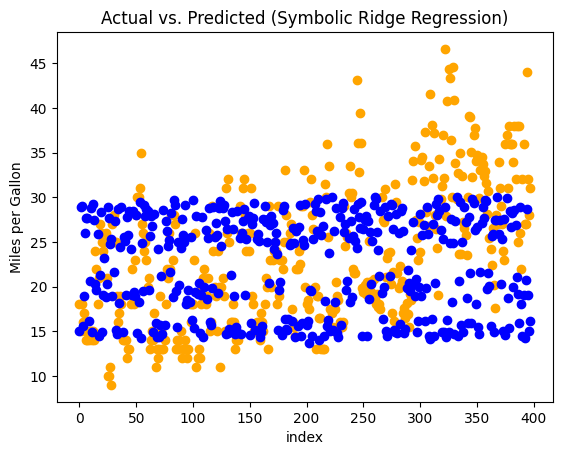

MAE: 3.0548
MSE: 18.4982
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Train and Test Symbolic Regression
R2:  0.6574
Adjusted R2:  0.6241


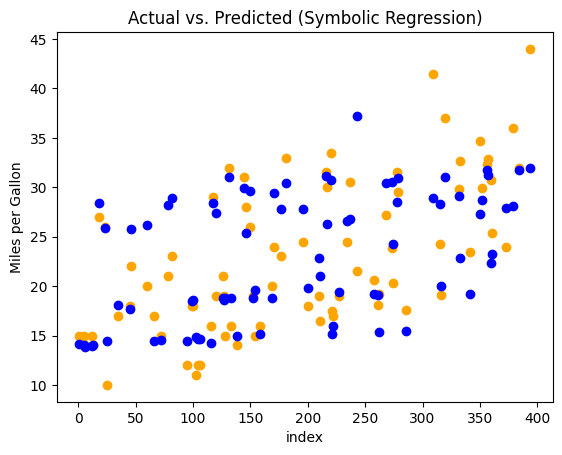

MAE: 3.1761
MSE: 19.3086
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Five Fold Cross Validation Symbolic Regression
Symbolic Regression Mean R-squared score: 0.712 (+/- 0.094)
Symbolic Regression Mean Adjusted R-squared score: 0.707 (+/- 0.096)
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Symbolic Ridge Regression
Cannot implement Symbolic Ridge Regression. No built in functionality apply lambda penalty to a loss function
Results from Symbolic Ridge Regression are the same as Symbolic Regression
----------------------------------------------------------------------------------------------------


In [12]:
print("-" * 100)
print(
    "In Sample Symbolic Regression"
)  # no need to utilize all column combinations in Symbolic regression

symbolicRegression = SymbolicRegressor(
    population_size=1000, generations=20, tournament_size=5, n_jobs=-1

)
symbolicRegression.fit(X, y)
# add(add(mul(add(div(X5, X0), X0), div(X5, X2)), mul(X0, 0.752)), X6)

# (((X5/X0) + X0) * (X5/X2)) + (X0*.752) + X6
# (((x_5 / x_0) + x_0) * (x_5 / x_2)) + (x_0 * 0.752) + x_6

y_predictions = symbolicRegression.predict(X)
# calculate and dispaly residual metrics
mae = mean_absolute_error(y, y_predictions)
mse = mean_squared_error(y, y_predictions)
r2 = r2_score(y, y_predictions)
adr2 = adjusted_r2_score(XTest=X, r2=r2)
print(f"R2: {r2 : .4f}")
print(f"Adjusted R2: {adr2 : .4f}")

plt.scatter(y.index, y, c="orange")
plt.scatter(pd.DataFrame(y_predictions).index, y_predictions, c="blue")
plt.title("Actual vs. Predicted (Symbolic Ridge Regression)")
plt.xlabel("index")
plt.ylabel("Miles per Gallon")
plt.show()

print(
    f"MAE: {mae:.4f}"
)  # MAE: average of the absoulte differences. Less sensitive to outliers
print(
    f"MSE: {mse:.4f}"
)  # MSE: average of the squared differences. More sensitive to outliers


print("-" * 100)

########################################################################################################################

print("-" * 100)
print(
    "Train and Test Symbolic Regression"
)  # no need to utilize all column combinations in Symbolic regression

symbolicRegression = SymbolicRegressor(
    population_size=1000, generations=20, tournament_size=5, n_jobs=-1
)
symbolicRegression.fit(X_train, y_train)

y_predictions = symbolicRegression.predict(X_test)
# calculate and dispaly residual metrics
mae = mean_absolute_error(y_test, y_predictions)
mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)
adr2 = adjusted_r2_score(XTest=X_test, r2=r2)
print(f"R2: {r2 : .4f}")
print(f"Adjusted R2: {adr2 : .4f}")

plt.scatter(y_test.index, y_test, c="orange")
plt.scatter(y_test.index, y_predictions, c="blue")
plt.title("Actual vs. Predicted (Symbolic Regression)")
plt.xlabel("index")
plt.ylabel("Miles per Gallon")
plt.show()

print(
    f"MAE: {mae:.4f}"
)  # MAE: average of the absoulte differences. Less sensitive to outliers
print(
    f"MSE: {mse:.4f}"
)  # MSE: average of the squared differences. More sensitive to outliers


print("-" * 100)

########################################################################################################################

print("-" * 100)
print("Five Fold Cross Validation Symbolic Regression")
symbolicRegression = SymbolicRegressor(
    population_size=1000, generations=20, tournament_size=5, n_jobs=-1
)
# Use cross-validation to evaluate the performance of the model
scores = cross_val_score(symbolicRegression, X, y, cv=5, scoring="r2")
# Calculate adjusted R-squared
adj_scores = [adj_r2_score(r2, X.shape[0], X.shape[1]) for r2 in scores]
# Print the mean score and standard deviation of the scores
print(
    "Symbolic Regression Mean R-squared score: %0.3f (+/- %0.3f)"
    % (np.mean(scores), np.std(scores) * 2)
)
print(
    "Symbolic Regression Mean Adjusted R-squared score: %0.3f (+/- %0.3f)"
    % (np.mean(adj_scores), np.std(adj_scores) * 2)
)
print("-" * 100)

########################################################################################################################

print("-" * 100)
print(
    "Symbolic Ridge Regression"
)  # no need to utilize all column combinations in Symbolic regression, only iterate through a lambda parameter space
print(
    "Cannot implement Symbolic Ridge Regression. No built in functionality apply lambda penalty to a loss function"
)
print("Results from Symbolic Ridge Regression are the same as Symbolic Regression")

print("-" * 100)

########################################################################################################################

# Transformed Regression

----------------------------------------------------------------------------------------------------
Transformed Regression
As indicated by our regular multiple regression, ridge regression, and lasso regression, the best performing model uses all 7 available input features.

Log Transformation on Explanatory variable
R2:  0.8568
Adjusted R2:  0.8542


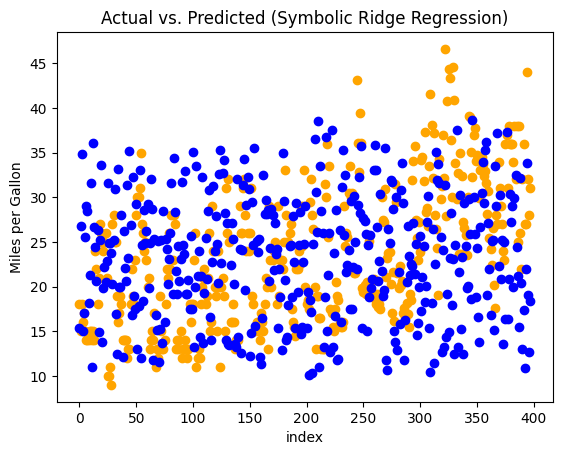

MAE: 2.1029
MSE: 8.7249

Square Root Transformation on Explanatory variable
R2:  0.6384
Adjusted R2:  0.6319


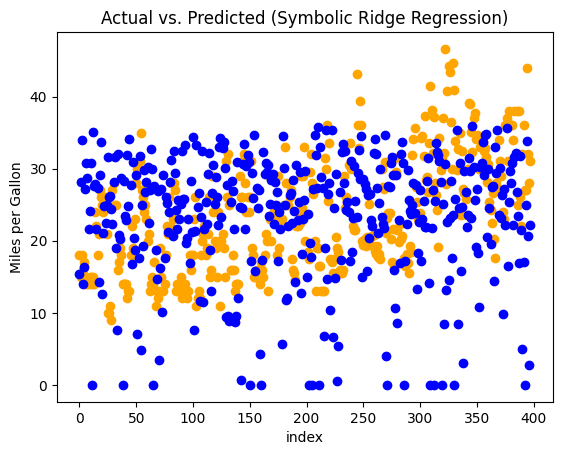

MAE: 3.5565
MSE: 22.0324

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Train and Test Transformed Regression
As indicated by our regular multiple regression, ridge regression, and lasso regression, the best performing model uses all 7 available input features.

Log Transformation on Explanatory variable
R2:  0.8417
Adjusted R2:  0.8263


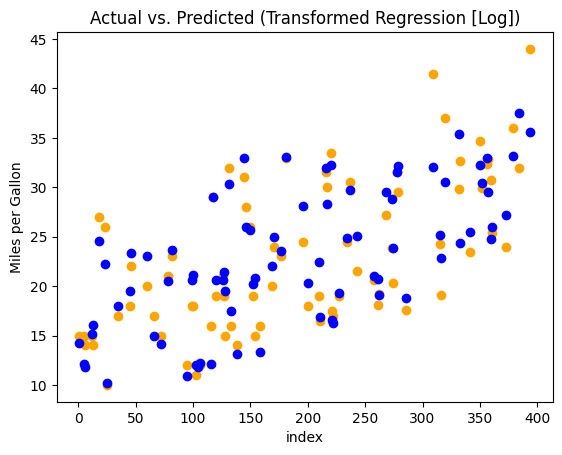

MAE: 2.1940
MSE: 8.9199

Square Root Transformation on Explanatory variable
R2:  0.5297
Adjusted R2:  0.5213


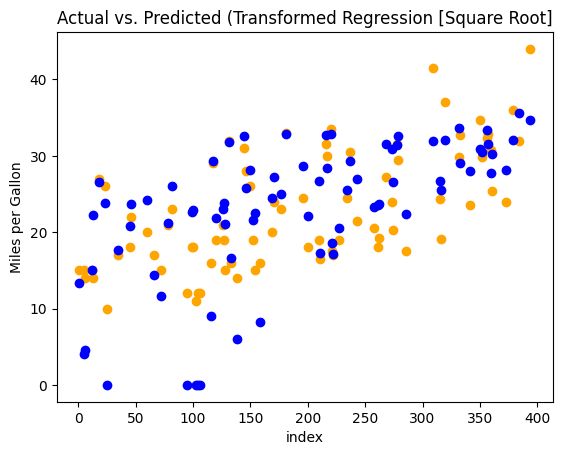

MAE: 4.0440
MSE: 26.5059

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Five Fold Cross Validation Transformed Regression
Log Transformed Regression Mean R-squared score: 0.875 (+/- 0.025)
Log Transformed Regression  Mean Adjusted R-squared score: 0.872 (+/- 0.026)


In [14]:
print("-" * 100)
print("Transformed Regression")
print(
    "As indicated by our regular multiple regression, ridge regression, and lasso regression, the best performing model uses all 7 available input features."
)
print()

ylog = y.apply(lambda x: emath.log(x))
print("Log Transformation on Explanatory variable")
logRegression = LinearRegression()
logRegression.fit(X, ylog)
y_predictions = logRegression.predict(X)
# map y predictions using inverse of transformation function
y_predictions = np.array([math.exp(x) for x in y_predictions])
# calculate and display residual metrics
mae = mean_absolute_error(y, y_predictions)
mse = mean_squared_error(y, y_predictions)
r2 = r2_score(y, y_predictions)
adr2 = adjusted_r2_score(XTest=X, r2=r2)
print(f"R2: {r2 : .4f}")
print(f"Adjusted R2: {adr2 : .4f}")
# visualize residuals
plt.scatter(y.index, y, c="orange")
plt.scatter(pd.DataFrame(y_predictions).index, y_predictions, c="blue")
plt.title("Actual vs. Predicted (Symbolic Ridge Regression)")
plt.xlabel("index")
plt.ylabel("Miles per Gallon")
plt.show()
print(
    f"MAE: {mae:.4f}"
)  # MAE: average of the absoulte differences. Less sensitive to outliers
print(
    f"MSE: {mse:.4f}"
)  # MSE: average of the squared differences. More sensitive to outliers
print()

yroot = y.apply(lambda x: x**2)
print("Square Root Transformation on Explanatory variable")
logRegression = LinearRegression()
logRegression.fit(X, yroot)
y_predictions = logRegression.predict(X)
# map y predictions using inverse of transformation function
y_predictions = np.array([math.sqrt(x) if x > 0 else 0 for x in y_predictions])
# calculate and display residual metrics
mae = mean_absolute_error(y, y_predictions)
mse = mean_squared_error(y, y_predictions)
r2 = r2_score(y, y_predictions)
adr2 = adjusted_r2_score(XTest=X, r2=r2)
print(f"R2: {r2 : .4f}")
print(f"Adjusted R2: {adr2 : .4f}")
# visualize residuals
plt.scatter(y.index, y, c="orange")
plt.scatter(pd.DataFrame(y_predictions).index, y_predictions, c="blue")
plt.title("Actual vs. Predicted (Symbolic Ridge Regression)")
plt.xlabel("index")
plt.ylabel("Miles per Gallon")
plt.show()
print(
    f"MAE: {mae:.4f}"
)  # MAE: average of the absoulte differences. Less sensitive to outliers
print(
    f"MSE: {mse:.4f}"
)  # MSE: average of the squared differences. More sensitive to outliers
print()

print("-" * 100)


print("-" * 100)
print("Train and Test Transformed Regression")
print(
    "As indicated by our regular multiple regression, ridge regression, and lasso regression, the best performing model uses all 7 available input features."
)
print()

ylogtrain = y_train.apply(lambda x: emath.log(x))
print("Log Transformation on Explanatory variable")
logRegression = LinearRegression()
logRegression.fit(X_train, ylogtrain)
y_predictions = logRegression.predict(X_test)
# map y predictions using inverse of transformation function
y_predictions = np.array([math.exp(x) for x in y_predictions])
# calculate and display residual metrics
mae = mean_absolute_error(y_test, y_predictions)
mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)
adr2 = adjusted_r2_score(XTest=X_test, r2=r2)
print(f"R2: {r2 : .4f}")
print(f"Adjusted R2: {adr2 : .4f}")
# visualize residuals
plt.scatter(y_test.index, y_test, c="orange")
plt.scatter(y_test.index, y_predictions, c="blue")
plt.title("Actual vs. Predicted (Transformed Regression [Log])")
plt.xlabel("index")
plt.ylabel("Miles per Gallon")
plt.show()
print(
    f"MAE: {mae:.4f}"
)  # MAE: average of the absoulte differences. Less sensitive to outliers
print(
    f"MSE: {mse:.4f}"
)  # MSE: average of the squared differences. More sensitive to outliers
print()

yroottrain = y_train.apply(lambda x: x**2)
print("Square Root Transformation on Explanatory variable")
logRegression = LinearRegression()
logRegression.fit(X_train, yroottrain)
y_predictions = logRegression.predict(X_test)
# map y predictions using inverse of transformation function
y_predictions = np.array([math.sqrt(x) if x > 0 else 0 for x in y_predictions])
# calculate and display residual metrics
mae = mean_absolute_error(y_test, y_predictions)
mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)
adr2 = adjusted_r2_score(XTest=X, r2=r2)
print(f"R2: {r2 : .4f}")
print(f"Adjusted R2: {adr2 : .4f}")
# visualize residuals
plt.scatter(y_test.index, y_test, c="orange")
plt.scatter(y_test.index, y_predictions, c="blue")
plt.title("Actual vs. Predicted (Transformed Regression [Square Root]")
plt.xlabel("index")
plt.ylabel("Miles per Gallon")
plt.show()
print(
    f"MAE: {mae:.4f}"
)  # MAE: average of the absoulte differences. Less sensitive to outliers
print(
    f"MSE: {mse:.4f}"
)  # MSE: average of the squared differences. More sensitive to outliers
print()

print("-" * 100)

########################################################################################################################

print("-" * 100)
print("Five Fold Cross Validation Transformed Regression")
# Create a copy of the data with log-transformed response variable
X = autompg.drop("mpg", axis=1)
ylog = y.apply(
    lambda x: emath.log(
        x
        + 0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001
    )
)
# Create a KFold object with 5 folds
kf = KFold(n_splits=5)
# Create a LinearRegression object
linearRegression = LinearRegression()
# Use cross-validation to evaluate the performance of the model
scores = cross_val_score(linearRegression, X, ylog, cv=kf, scoring="r2")
# Calculate adjusted R-squared
n = len(ylog)
p = X.shape[1]
adj_scores = [1 - ((1 - r2) * (n - 1) / (n - p - 1)) for r2 in scores]
# Print the mean score and standard deviation of the scores
print(
    "Log Transformed Regression Mean R-squared score: %0.3f (+/- %0.3f)"
    % (np.mean(scores), np.std(scores) * 2)
)
print(
    "Log Transformed Regression  Mean Adjusted R-squared score: %0.3f (+/- %0.3f)"
    % (np.mean(adj_scores), np.std(adj_scores) * 2)
)